Sprint 1: Preliminary analysis and ETL pipeline construction

EDA

In [2]:
from pyspark.sql import SparkSession



spark = (
    SparkSession.builder.appName("MAST30034 project2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)




In [3]:
import pandas as pd

d:\anaconda\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [4]:
import os
import sys

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.functions import when, count
from pyspark.sql import functions as F
from pyspark.sql.functions import col, regexp_extract 
from pyspark.sql.functions import sum, max
from pyspark.sql.functions import split

In [5]:
folder_path1 = '../data/tables/transactions_20210228_20210827_snapshot'
df1 = spark.read.parquet(folder_path1)

folder_path2 = '../data/tables/transactions_20210828_20220227_snapshot'
df2 = spark.read.parquet(folder_path2)

folder_path3 = '../data/tables/transactions_20220228_20220828_snapshot'
df3 = spark.read.parquet(folder_path3)
transaction = df1.union(df2).union(df3).drop("order_id")





In [6]:
type(transaction)

pyspark.sql.dataframe.DataFrame

In [7]:
df1.show(5)
transaction.show(5)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 5 rows

+-------+------------+------------------+--------------+
|user_id|merchant_abn|      dollar_value|order_datetime|
+-------+------------+------------------+--------------+
|  18478| 62191208634|63.255848959735246|    2021-08-20|
|      2| 15549624934| 130.3505283105634|    

In [8]:
# Loading the dataset

c_match = spark.read.parquet("../data/tables/consumer_user_details.parquet")
c_raw_detail = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep = '|')
m_detail = spark.read.parquet('../data/tables/tbl_merchants.parquet')
m_fraud = spark.read.csv("../data/tables/merchant_fraud_probability.csv", header=True)
c_fraud = spark.read.csv("../data/tables/consumer_fraud_probability.csv", header=True)
c_detail = c_raw_detail.join(c_match, c_raw_detail["consumer_id"]==c_match["consumer_id"]).drop("consumer_id","name","address","gender")

In [9]:
c_fraud.show(5)

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
|   3101|    2021-04-17|91.42192091901347|
|  22239|    2021-10-19|94.70342477508035|
+-------+--------------+-----------------+
only showing top 5 rows



In [10]:
m_fraud.show(5)

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
| 82999039227|    2021-12-19|  94.1347004808891|
| 90918180829|    2021-09-02| 43.32551731714902|
+------------+--------------+------------------+
only showing top 5 rows



In [11]:
c_raw_detail.show(5)

+-----------------+--------------------+-----+--------+------+-----------+
|             name|             address|state|postcode|gender|consumer_id|
+-----------------+--------------------+-----+--------+------+-----------+
| Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|    1195503|
|       Mary Smith|     3764 Amber Oval|  NSW|    2782|Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|   NT|     862|Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|  NSW|    2780|Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|   WA|    6355|Female|     712975|
+-----------------+--------------------+-----+--------+------+-----------+
only showing top 5 rows



In [12]:
c_detail.show(5)

+-----+--------+-------+
|state|postcode|user_id|
+-----+--------+-------+
|   WA|    6935|      1|
|  NSW|    2782|      2|
|   NT|     862|      3|
|  NSW|    2780|      4|
|   WA|    6355|      5|
+-----+--------+-------+
only showing top 5 rows



In [13]:
m_detail.show(5)

+--------------------+--------------------+------------+
|                name|                tags|merchant_abn|
+--------------------+--------------------+------------+
|       Felis Limited|((furniture, home...| 10023283211|
|Arcu Ac Orci Corp...|([cable, satellit...| 10142254217|
|    Nunc Sed Company|([jewelry, watch,...| 10165489824|
|Ultricies Digniss...|([wAtch, clock, a...| 10187291046|
| Enim Condimentum PC|([music shops - m...| 10192359162|
+--------------------+--------------------+------------+
only showing top 5 rows



In [14]:
# See basic information about the dataset
m_detail.printSchema()
transaction.printSchema()
c_raw_detail.printSchema()

root
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- merchant_abn: long (nullable = true)

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_datetime: date (nullable = true)

root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- consumer_id: string (nullable = true)



In [15]:
# 分割 'tags' 字段，并展开为多个列
split_col = split(col("tags"), "\\|")

# 假设最多有三个标签，可以根据实际情况增减
m_detail = m_detail.withColumn("tag", split_col.getItem(0))
# 展示更新后的DataFrame
m_detail.select("name", "tag").show(truncate=False)

+------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|name                                |tag                                                                                                              |
+------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|Felis Limited                       |((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))|
|Arcu Ac Orci Corporation            |([cable, satellite, and otHer pay television and radio services], [b], [take rate: 4.22])                        |
|Nunc Sed Company                    |([jewelry, watch, clock, and silverware shops], [b], [take rate: 4.40])                                          |
|Ultricies Dignissim Lacus Foundation|([wAtch, clock, and jewelry repair shops], [

In [16]:
from pyspark.sql.functions import col, regexp_replace, regexp_extract

# 消除tags中的方括号和圆括号
m_detail = m_detail.withColumn("tags", regexp_replace(col("tags"), "\\[", "("))
m_detail = m_detail.withColumn("tags", regexp_replace(col("tags"), "\\]", ")"))

# 提取revenue_level，使用正确的转义字符
pattern = "\\(([a-e])\\)"  # 使用双反斜杠来转义圆括号
m_detail = m_detail.withColumn("revenue_level", regexp_extract(col("tags"), pattern, 1))

# 定义正则表达式匹配 take rate
pattern_take_rate = "take rate: (\d+\.\d+)"

# 在 DataFrame 中添加 take_rate 列
m_detail = m_detail.withColumn("take_rate", regexp_extract(col("tags"), pattern_take_rate, 1))

# 显示 name, revenue_level, 和 take_rate
m_detail.select("name", "revenue_level", "take_rate").show(truncate=False)

+------------------------------------+-------------+---------+
|name                                |revenue_level|take_rate|
+------------------------------------+-------------+---------+
|Felis Limited                       |e            |0.18     |
|Arcu Ac Orci Corporation            |b            |4.22     |
|Nunc Sed Company                    |b            |4.40     |
|Ultricies Dignissim Lacus Foundation|b            |3.29     |
|Enim Condimentum PC                 |a            |6.33     |
|Fusce Company                       |a            |6.34     |
|Aliquam Enim Incorporated           |b            |4.32     |
|Ipsum Primis Ltd                    |c            |2.39     |
|Pede Ultrices Industries            |a            |5.71     |
|Nunc Inc.                           |a            |6.61     |
|Facilisis Facilisis Corp.           |a            |6.34     |
|Odio Institute                      |b            |3.57     |
|Rutrum Justo Ltd                    |b            |3.6

In [17]:
from pyspark.sql import functions as F

# 假设 m_detail 是你的 DataFrame，已经包含正确的 revenue_level 和 take_rate 列
# 首先，确保 take_rate 是数值类型
m_detail = m_detail.withColumn("take_rate", m_detail["take_rate"].cast("float"))

# 使用 groupBy 和 agg 方法计算每个 revenue_level 的最小和最大 take_rate
stats_df = m_detail.groupBy("revenue_level").agg(
    F.min("take_rate").alias("min_take_rate"),
    F.max("take_rate").alias("max_take_rate")
)

# 转换为 Pandas DataFrame 以便查看结果
pandas_df = stats_df.toPandas()
print(pandas_df)


  revenue_level  min_take_rate  max_take_rate
0             e           0.10           0.48
1             d           0.52           1.40
2             c           1.40           3.10
3             b           3.10           5.10
4             a           5.50           7.00


In [18]:
# Calculate total revenue for each merchant
merchant_revenue = transaction.groupBy("merchant_abn").agg({"dollar_value": "sum"})

# Rename the aggregated column to 'total_revenue'
merchant_revenue = merchant_revenue.withColumnRenamed("sum(dollar_value)", "total_revenue")

# Show the result
merchant_revenue.show(10)  # Display the top 10 results


+------------+------------------+
|merchant_abn|     total_revenue|
+------------+------------------+
| 38700038932| 9546185.360697314|
| 83412691377| 498536.5816973136|
| 15613631617| 543030.5313328261|
| 19839532017|          113982.0|
| 73256306726| 1496967.159114219|
| 35344855546|134737.25046268434|
| 24406529929|  280125.230897664|
| 73841664453| 83314.29045077678|
| 78916025936|21015.671086215083|
| 60654402457| 17030.97660860815|
+------------+------------------+
only showing top 10 rows



In [19]:
# Step 1: Calculate customer count by counting distinct 'user_id' from `transaction`
customer_count_df = transaction.groupBy("merchant_abn").agg(F.countDistinct("user_id").alias("customer_count"))

# Step 2: Calculate total revenue by summing 'dollar_value' for each 'merchant_abn'
merchant_revenue = transaction.groupBy("merchant_abn").agg(F.sum("dollar_value").alias("total_revenue"))

# Step 3: Join the customer_count and total_revenue back to the `merchants` DataFrame (m_detail)
# Ensure `merchant_abn` column types match in `customer_count_df` and `merchant_revenue`
m_detail = m_detail.withColumn("merchant_abn", m_detail["merchant_abn"].cast("long"))
merchants = m_detail.join(customer_count_df, on="merchant_abn", how="left").join(merchant_revenue, on="merchant_abn", how="left")

# Step 4: Fill any missing values for `customer_count` and `total_revenue`
merchants = merchants.fillna({"customer_count": 0, "total_revenue": 0.0})

# Step 5: Calculate new feature: revenue per customer
merchants = merchants.withColumn("revenue_per_customer", merchants["total_revenue"] / merchants["customer_count"])

# Handle division by zero (when customer_count is zero, set revenue_per_customer to 0)
merchants = merchants.withColumn("revenue_per_customer", F.when(F.col("customer_count") == 0, 0).otherwise(F.col("revenue_per_customer")))

# Display the final result
merchants.show(10)

+------------+--------------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+
|merchant_abn|                name|                tags|                 tag|revenue_level|take_rate|customer_count|     total_revenue|revenue_per_customer|
+------------+--------------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+
| 12516851436|        Mollis Corp.|((watch, clock, a...|((watch, clock, a...|            a|     6.71|           210|32325.484349738046|  153.93087785589546|
| 15613631617|     Ante Industries|((motor vehicle s...|[[motor vehicle s...|            e|     0.35|          1714| 543030.5313328261|  316.82061337971186|
| 19839532017|Pellentesque Habi...|((cable, Satellit...|([cable, Satellit...|            b|     4.94|           714|          113982.0|   159.6386554621849|
| 34440496342|Mauris Nulla Inte...|((opticians, opti...|((

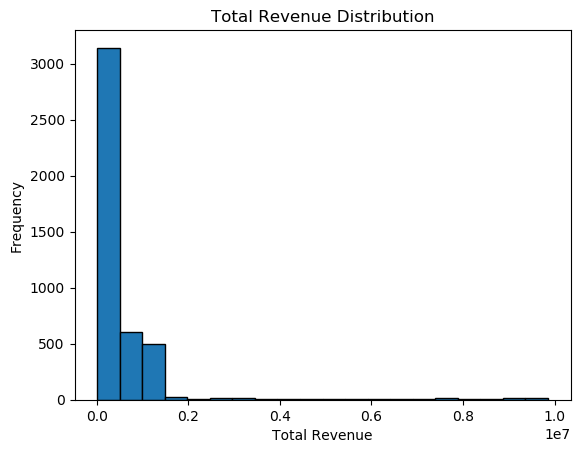

In [20]:
merchant_revenue_pd = merchant_revenue.toPandas()

# Overview of the data distribution

plt.hist(merchant_revenue_pd["total_revenue"], bins=20, edgecolor='black')
plt.title('Total Revenue Distribution')
plt.xlabel('Total Revenue')
plt.ylabel('Frequency')
plt.show()



In [21]:
# Finding missing values
from pyspark.sql.functions import col, sum

# Check missing values in each column of m_detail
m_detail.select([sum(col(column).isNull().cast("int")).alias(column) for column in m_detail.columns]).show()

# Check missing values in each column of transaction
transaction.select([sum(col(column).isNull().cast("int")).alias(column) for column in transaction.columns]).show()

# Check missing values in each column of c_raw_detail
c_raw_detail.select([sum(col(column).isNull().cast("int")).alias(column) for column in c_raw_detail.columns]).show()



+----+----+------------+---+-------------+---------+
|name|tags|merchant_abn|tag|revenue_level|take_rate|
+----+----+------------+---+-------------+---------+
|   0|   0|           0|  0|            0|        0|
+----+----+------------+---+-------------+---------+

+-------+------------+------------+--------------+
|user_id|merchant_abn|dollar_value|order_datetime|
+-------+------------+------------+--------------+
|      0|           0|           0|             0|
+-------+------------+------------+--------------+

+----+-------+-----+--------+------+-----------+
|name|address|state|postcode|gender|consumer_id|
+----+-------+-----+--------+------+-----------+
|   0|      0|    0|       0|     0|          0|
+----+-------+-----+--------+------+-----------+



In [22]:
# Save as a single CSV file

# Convert the PySpark DataFrame to a Pandas DataFrame
transaction_pd = transaction.toPandas()
# Save the Pandas DataFrame as a CSV file
#transaction_pd.to_csv('C:/Users/HuangHan/Desktop/transaction.csv', index=False)
# Taking a sample of 10,000 rows
transaction_sample = transaction.limit(20000).toPandas()
transaction_sample.to_csv('../data/curated/transaction_sample.csv', index=False)




In [23]:
m_detail = m_detail.withColumnRenamed("name", "merchant_name")
c_raw_detail = c_raw_detail.withColumnRenamed("name", "customer_name")

In [24]:
m_detail.show(5)

+--------------------+--------------------+------------+--------------------+-------------+---------+
|       merchant_name|                tags|merchant_abn|                 tag|revenue_level|take_rate|
+--------------------+--------------------+------------+--------------------+-------------+---------+
|       Felis Limited|((furniture, home...| 10023283211|((furniture, home...|            e|     0.18|
|Arcu Ac Orci Corp...|((cable, satellit...| 10142254217|([cable, satellit...|            b|     4.22|
|    Nunc Sed Company|((jewelry, watch,...| 10165489824|([jewelry, watch,...|            b|      4.4|
|Ultricies Digniss...|((wAtch, clock, a...| 10187291046|([wAtch, clock, a...|            b|     3.29|
| Enim Condimentum PC|((music shops - m...| 10192359162|([music shops - m...|            a|     6.33|
+--------------------+--------------------+------------+--------------------+-------------+---------+
only showing top 5 rows



In [25]:
m_detail.printSchema()
transaction.printSchema()
c_raw_detail.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- tag: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: float (nullable = true)

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_datetime: date (nullable = true)

root
 |-- customer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- consumer_id: string (nullable = true)



Develop an ETL pipeline

In [26]:
merged_data1 = transaction.join(merchants, on='merchant_abn', how='left')
merged_data1.show(5)

+------------+-------+------------------+--------------+------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+
|merchant_abn|user_id|      dollar_value|order_datetime|        name|                tags|                 tag|revenue_level|take_rate|customer_count|     total_revenue|revenue_per_customer|
+------------+-------+------------------+--------------+------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+
| 12516851436|  14027| 49.77527691818967|    2021-08-16|Mollis Corp.|((watch, clock, a...|((watch, clock, a...|            a|     6.71|           210|32325.484349738046|  153.93087785589546|
| 12516851436|   7649| 40.85182144169601|    2021-08-13|Mollis Corp.|((watch, clock, a...|((watch, clock, a...|            a|     6.71|           210|32325.484349738046|  153.93087785589546|
| 12516851436|   1014|141.84165902875668|    

In [27]:
merged_data = transaction.join(merchants, on='merchant_abn', how='left')
merged_data = merged_data.join(c_raw_detail, merged_data["user_id"] == c_raw_detail["consumer_id"], how='left') 
merged_data = merged_data.drop("consumer_id")

merged_data = merged_data.drop("tag")
merged_data.show(10)

+------------+-------+------------------+--------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+-------------+-----------------+-----+--------+------+
|merchant_abn|user_id|      dollar_value|order_datetime|                name|                tags|revenue_level|take_rate|customer_count|     total_revenue|revenue_per_customer|customer_name|          address|state|postcode|gender|
+------------+-------+------------------+--------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+-------------+-----------------+-----+--------+------+
| 83412691377|     26|   51.124963532657|    2021-12-06|Suspendisse Sagit...|((watch, clock, a...|            c|     2.94|         10770| 498536.5816973136|  46.289376202164675|Chloe Walters|04666 Castro Hill|  VIC|    3026|Female|
| 83412691377|     26| 37.59252664573718|    2022-06-15|Suspendisse Sagi

In [28]:
merchant_features = transaction.groupBy("merchant_abn").agg(
    F.sum("dollar_value").alias("total_revenue"),          # Ensure 'dollar_value' exists
    F.countDistinct("user_id").alias("unique_customers"),  # Ensure 'consumer_id' exists
    F.avg("dollar_value").alias("average_transaction_value")   # Ensure 'dollar_value' exists
)

In [29]:
!pip install pyod
!pip install statsmodels

  Using cached https://files.pythonhosted.org/packages/9d/20/0ffe8665a44bce7616bd33d4368a198fecad3b226bcafa38c63ef0f6286f/scikit_learn-1.0.2-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/ad/5a/b79eda6012461c4dea6c5c4122c7438843d617f960d2d635f044a97ab912/numba-0.56.4-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/40/69/4af412d078cef2298f7d90546fa0e03e65a032558bd85319239c72ae0c3c/scipy-1.7.3-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/61/cf/6e354304bcb9c6413c4e02a747b600061c21d38ba51e7e544ac7bc66aecc/threadpoolctl-3.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/be/05/af5fd325c52b73255a51691300f00b06177dfe1088b90ea20dd49c6e0c23/llvmlite-0.39.1-cp37-cp37m-win_amd64.whl
  Found existing installation: scipy 1.2.1
    Uninstalling scipy-1.2.1:
      Successfully uninstalled scipy-1.2.1
  Found existing installation: scikit-learn 0.21.2
    Uninstalling scikit-le

ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, countDistinct, avg
from sklearn.ensemble import IsolationForest

ImportError: DLL load failed: 找不到指定的模块。

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, countDistinct, avg
from sklearn.ensemble import IsolationForest

# Step 2: Feature Engineering for Merchant Anomaly Detection
# Calculate total revenue, number of unique customers, and average transaction value for each merchant
merchant_features = transaction.groupBy("merchant_abn").agg(
    F.sum("dollar_value").alias("total_revenue"),  
    F.countDistinct("user_id").alias("unique_customers"), 
    F.avg("dollar_value").alias("average_transaction_value") 
)

# Convert to Pandas DataFrame for use with Scikit-learn
merchant_features_pd = merchant_features.toPandas()

# Step 3: Handle missing or infinite values (if any)
merchant_features_pd = merchant_features_pd.fillna(0)
merchant_features_pd = merchant_features_pd.replace([float('inf'), -float('inf')], 0)

# Step 4: Anomaly Detection using Isolation Forest
# Initialize and fit the Isolation Forest model
merchant_model = IsolationForest(contamination=0.05, random_state=42)
merchant_features_pd['anomaly'] = merchant_model.fit_predict(
    merchant_features_pd[["total_revenue", "unique_customers", "average_transaction_value"]]
)

# Convert predictions back to Spark DataFrame
merchant_anomalies = spark.createDataFrame(merchant_features_pd)

# Step 5: Show the results
# Display the merchants classified as anomalies
merchant_anomalies.filter(merchant_anomalies['anomaly'] == -1).show()

# Optional: Save the results to a CSV or Parquet file for further analysis
# merchant_anomalies.write.parquet("merchant_anomalies.parquet", mode='overwrite')


ImportError: DLL load failed: 找不到指定的模块。

In [36]:
customer_features = transaction.groupBy("user_id").agg(
    F.sum("dollar_value").alias("total_spent"),           # Total spending by the customer
    F.count("dollar_value").alias("transaction_count"),   # Number of transactions
    F.avg("dollar_value").alias("average_transaction_value")  # Average value of each transaction
)

# Convert the customer features Spark DataFrame to a Pandas DataFrame for use with Scikit-learn
customer_features_pd = customer_features.toPandas()

# Handle any missing or infinite values (if present)
customer_features_pd = customer_features_pd.fillna(0)
customer_features_pd = customer_features_pd.replace([float('inf'), -float('inf')], 0)

# Display the first few rows to ensure proper conversion and handling
print(customer_features_pd.head())

# Initialize the Isolation Forest model
customer_model = IsolationForest(contamination=0.05, random_state=42)

# Train the Isolation Forest model on the customer features
# We use total_spent, transaction_count, and average_transaction_value as the features
customer_model.fit(customer_features_pd[["total_spent", "transaction_count", "average_transaction_value"]])

# Predict anomalies: -1 for outliers, 1 for inliers
customer_features_pd["anomaly"] = customer_model.predict(
    customer_features_pd[["total_spent", "transaction_count", "average_transaction_value"]]
)

# Display the number of anomalies detected
print("Number of anomalies detected:", (customer_features_pd["anomaly"] == -1).sum())

# Display a sample of the customers classified as anomalies
print(customer_features_pd[customer_features_pd["anomaly"] == -1].head())

# Convert the Pandas DataFrame back to a Spark DataFrame for further processing or saving
customer_anomalies = spark.createDataFrame(customer_features_pd)

# Show the anomalies in the Spark DataFrame
customer_anomalies.filter(customer_anomalies["anomaly"] == -1).show(10)

# Save the anomalies to a Parquet file for future analysis or reporting
# customer_anomalies.write.parquet("customer_anomalies.parquet", mode='overwrite')



   user_id    total_spent  transaction_count  average_transaction_value
0       26   94290.066114                588                 160.357255
1    18730   96322.244891                581                 165.786996
2      474  114137.088671                597                 191.184403
3    19141  109441.631247                597                 183.319315
4    19158   96380.828902                582                 165.602799


NameError: name 'IsolationForest' is not defined

In [40]:
# Step 1: Calculate customer count by counting distinct 'user_id' from `transaction`
customer_count_df = transaction.groupBy("merchant_abn").agg(F.countDistinct("user_id").alias("customer_count"))

# Step 2: Calculate total revenue by summing 'dollar_value' for each 'merchant_abn'
merchant_revenue = transaction.groupBy("merchant_abn").agg(F.sum("dollar_value").alias("total_revenue"))

# Step 3: Join the customer_count and total_revenue back to the `merchants` DataFrame (m_detail)
# Ensure `merchant_abn` column types match in `customer_count_df` and `merchant_revenue`
m_detail = m_detail.withColumn("merchant_abn", m_detail["merchant_abn"].cast("long"))
merchants = m_detail.join(customer_count_df, on="merchant_abn", how="left").join(merchant_revenue, on="merchant_abn", how="left")

# Step 4: Fill any missing values for `customer_count` and `total_revenue`
merchants = merchants.fillna({"customer_count": 0, "total_revenue": 0.0})

# Step 5: Calculate new feature: revenue per customer
merchants = merchants.withColumn("revenue_per_customer", merchants["total_revenue"] / merchants["customer_count"])

# Handle division by zero (when customer_count is zero, set revenue_per_customer to 0)
merchants = merchants.withColumn("revenue_per_customer", F.when(F.col("customer_count") == 0, 0).otherwise(F.col("revenue_per_customer")))

merchants = merchants.fillna({'total_revenue': merchants.agg(F.mean('total_revenue')).first()[0]})
transaction = transaction.dropna(subset=["dollar_value"])
c_raw_detail = c_raw_detail.fillna('Unknown')

# Data transformation: generate new features correctly using column expressions
merchants = merchants.withColumn(
    "revenue_per_customer", 
    F.col("total_revenue") / F.col("customer_count")
)

# Data merging: join DataFrames correctly using PySpark's join method
m_detail = m_detail.withColumnRenamed("name", "merchant_name")
c_raw_detail = c_raw_detail.withColumnRenamed("name", "customer_name")
    
merged_data = transaction.join(merchants, on="merchant_abn", how="left")
merged_data = merged_data.join(c_raw_detail, merged_data["user_id"] == c_raw_detail["consumer_id"], how="left")
merged_data = merged_data.drop("consumer_id")
merged_data = merged_data.drop("tag")

In [41]:
print("Columns in merged_data before saving:", merged_data.columns)


Columns in merged_data before saving: ['merchant_abn', 'user_id', 'dollar_value', 'order_datetime', 'merchant_name', 'tags', 'revenue_level', 'take_rate', 'customer_count', 'total_revenue', 'revenue_per_customer', 'customer_name', 'address', 'state', 'postcode', 'gender']


In [42]:
merged_data.show(5)

+------------+-------+-----------------+--------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+-------------+-----------------+-----+--------+------+
|merchant_abn|user_id|     dollar_value|order_datetime|       merchant_name|                tags|revenue_level|take_rate|customer_count|     total_revenue|revenue_per_customer|customer_name|          address|state|postcode|gender|
+------------+-------+-----------------+--------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+-------------+-----------------+-----+--------+------+
| 83412691377|     26|  51.124963532657|    2021-12-06|Suspendisse Sagit...|((watch, clock, a...|            c|     2.94|         10770| 498536.5816973136|  46.289376202164675|Chloe Walters|04666 Castro Hill|  VIC|    3026|Female|
| 83412691377|     26|37.59252664573718|    2022-06-15|Suspendisse Sagit...|

In [43]:
merged_data.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- customer_count: long (nullable = true)
 |-- total_revenue: double (nullable = true)
 |-- revenue_per_customer: double (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)



In [126]:
merged_data.show(5)

+------------+-------+-----------------+--------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+-------------+-----------------+-----+--------+------+
|merchant_abn|user_id|     dollar_value|order_datetime|       merchant_name|                tags|revenue_level|take_rate|customer_count|     total_revenue|revenue_per_customer|customer_name|          address|state|postcode|gender|
+------------+-------+-----------------+--------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+-------------+-----------------+-----+--------+------+
| 83412691377|     26|  51.124963532657|    2021-12-06|Suspendisse Sagit...|((watch, clock, a...|            c|     2.94|         10770| 498536.5816973136|  46.289376202164675|Chloe Walters|04666 Castro Hill|  VIC|    3026|Female|
| 83412691377|     26|37.59252664573718|    2022-06-15|Suspendisse Sagit...|

In [44]:
# Outlier analysis (example: using IQR method to identify outliers)
# Convert the column to a Pandas Series
dollar_value_pd = merged_data.select('dollar_value').toPandas()

# Calculate the quantiles using Pandas
Q1 = dollar_value_pd['dollar_value'].quantile(0.25)
Q3 = dollar_value_pd['dollar_value'].quantile(0.75)
IQR = Q3 - Q1

# Filter out the outliers in the Spark DataFrame
outliers = merged_data.filter(
    (merged_data['dollar_value'] < (Q1 - 1.5 * IQR)) | 
    (merged_data['dollar_value'] > (Q3 + 1.5 * IQR))
)

print(f"Number of outliers: {outliers.count()}")



Number of outliers: 1534230


In [45]:
# Handling missing values

# Calculate the mean value for `dollar_value` column
mean_dollar_value = merged_data.agg({"dollar_value": "mean"}).collect()[0][0]

# Fill missing `dollar_value` with the mean value
merged_data_filled = merged_data.fillna({"dollar_value": mean_dollar_value})


merged_data_filled = merged_data_filled.fillna({"merchant_name": "Unknown", "customer_name": "Unknown"})

merged_data_filled.show(5)


+------------+-------+-----------------+--------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+-------------+-----------------+-----+--------+------+
|merchant_abn|user_id|     dollar_value|order_datetime|       merchant_name|                tags|revenue_level|take_rate|customer_count|     total_revenue|revenue_per_customer|customer_name|          address|state|postcode|gender|
+------------+-------+-----------------+--------------+--------------------+--------------------+-------------+---------+--------------+------------------+--------------------+-------------+-----------------+-----+--------+------+
| 83412691377|     26|  51.124963532657|    2021-12-06|Suspendisse Sagit...|((watch, clock, a...|            c|     2.94|         10770| 498536.5816973136|  46.289376202164675|Chloe Walters|04666 Castro Hill|  VIC|    3026|Female|
| 83412691377|     26|37.59252664573718|    2022-06-15|Suspendisse Sagit...|

In [46]:
merged_data_filled.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = false)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = false)
 |-- tags: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- customer_count: long (nullable = true)
 |-- total_revenue: double (nullable = true)
 |-- revenue_per_customer: double (nullable = true)
 |-- customer_name: string (nullable = false)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)



In [47]:
print("Number of missing values in dollar_value column:", merged_data_filled.filter(merged_data_filled['dollar_value'].isNull()).count())


Number of missing values in dollar_value column: 0


In [48]:
# Visualize the data distribution before and after outlier processing
# Convert to Pandas DataFrame for visualization
merged_data_filled_pd = merged_data_filled.limit(10000000).toPandas()
merged_data_filled_reduced = merged_data_filled.select("dollar_value")
merged_data_filled_pd = merged_data_filled_reduced.toPandas()


sns.boxplot(x=merged_data_filled_pd['dollar_value'])
plt.title('Transaction Amount Distribution After Outlier Removal')
plt.show()

Py4JJavaError: An error occurred while calling o470.collectToPython.
: org.apache.spark.SparkException: Job 48 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:956)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:954)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:954)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:2221)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2134)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:1967)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1357)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1967)
	at org.apache.spark.SparkContext$$anon$3.run(SparkContext.scala:1916)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:467)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:420)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3448)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3616)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:763)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3614)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3445)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)


In [52]:
# Look at the revenue distribution of merchants Look at the revenue distribution of merchants
sns.histplot(merged_data_filled['total_revenue'], bins=30)
plt.title('Merchant Total Revenue Distribution')
plt.show()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:65286)
Traceback (most recent call last):
  File "d:\anaconda\lib\site-packages\py4j\java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\anaconda\lib\site-packages\py4j\java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] 由于目标计算机积极拒绝，无法连接。


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:65286)

In [51]:

# 初步洞察：哪些特征对商户排序影响最大
corr_matrix = merged_data_filled.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

TypeError: corr() missing 2 required positional arguments: 'col1' and 'col2'